<a href="https://colab.research.google.com/github/Chimamuelo/Coding-Nomads-Deep-Learning-1/blob/master/Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Load Data

In [ ]:
df=pd.read_csv('https://raw.githubusercontent.com/Chimamuelo/House_price/master/train.csv')
df_test=pd.read_csv('https://raw.githubusercontent.com/Chimamuelo/House_price/master/test.csv')

In [ ]:
df.drop('Id',axis=1,inplace=True)
test_id=df_test['Id'].astype(int)
df_test.drop('Id',axis=1,inplace=True)

In [ ]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
print(df.shape,df_test.shape)


(1460, 80) (1459, 79)


In [ ]:
nan_features=nan_features=np.array(np.where(df.isna().sum()>1000))
nan_features=list(nan_features)

In [ ]:
for i in nan_features:
   df.drop(df.columns[i],axis=1,inplace=True)
   df_test.drop(df_test.columns[i],axis=1,inplace=True)

In [ ]:
df_test.isna().sum()

MSSubClass         0
MSZoning           4
LotFrontage      227
LotArea            0
Street             0
                ... 
MiscVal            0
MoSold             0
YrSold             0
SaleType           1
SaleCondition      0
Length: 75, dtype: int64

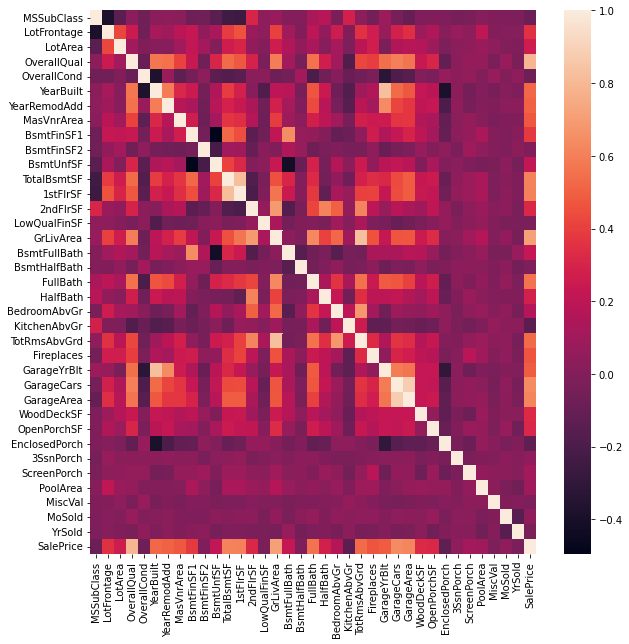

In [ ]:
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df.corr(), ax=ax)


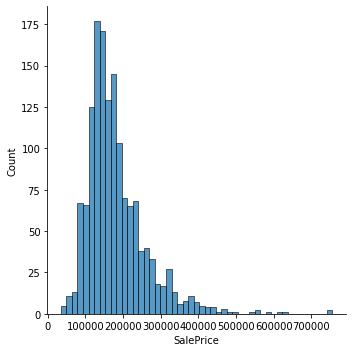

In [ ]:
sns.displot(df['SalePrice'])

# Pure torch model

In [ ]:
!pip install torchmetrics attrdict -q

     |████████████████████████████████| 419 kB 5.1 MB/s 


In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torchmetrics

from torch.utils.data import Dataset, DataLoader

In [ ]:
from fastai.tabular.all import *

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
df['MSSubClass']=df['MSSubClass'].astype('category')

In [ ]:
df['MSSubClass'].unique()

[60, 20, 70, 50, 190, ..., 80, 160, 75, 180, 40]
Length: 15
Categories (15, int64): [20, 30, 40, 45, ..., 120, 160, 180, 190]

In [ ]:
bins=list(df['MSSubClass'].unique())
bins

[60, 20, 70, 50, 190, 45, 90, 120, 30, 85, 80, 160, 75, 180, 40]

In [ ]:
cut=['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O']

In [ ]:
df['MSSubClass']=df['MSSubClass'].replace(bins,cut)
df_test['MSSubClass']=df_test['MSSubClass'].replace(bins,cut)

In [ ]:
le=LabelEncoder()
df['MSSubClass']=le.fit_transform(df['MSSubClass'])
df_test=le.fit_transform(df['MSSubClass'])

In [ ]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,A,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,B,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,A,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,C,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,A,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000


In [ ]:
obj_list=df.select_dtypes(['object'])
cat=list(obj_list.columns)

In [ ]:
cat

['MSSubClass',
 'MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'SaleType',
 'SaleCondition']

In [ ]:
cont_list=df.select_dtypes('number')
cont_list=cont_list.drop('SalePrice',axis=1)
cont=list(cont_list.columns)
cont

['LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']

In [ ]:
dls = TabularDataLoaders.from_csv('https://raw.githubusercontent.com/Chimamuelo/House_price/master/train.csv','https://raw.githubusercontent.com/Chimamuelo/House_price/master', y_names="SalePrice",
    cat_names = cat,
    cont_names =cont,
    procs = [Categorify(), FillMissing(fill_strategy=FillStrategy.mode), Normalize()])

In [ ]:
splits = RandomSplitter(valid_pct=0.2)(range_of(df))

In [ ]:
to = TabularPandas(df, procs=[Categorify, FillMissing(fill_strategy=FillStrategy.mode)],
                   cat_names = cat,
                   cont_names = cont,
                   y_names='SalePrice',
                   splits=splits)

In [ ]:
test = TabularPandas(df, procs=[Categorify, FillMissing(fill_strategy=FillStrategy.mode)],
                   cat_names = cat,
                   cont_names = cont,
                   
                   splits=splits)

In [ ]:
test.xs.iloc[:2]

,MSSubClass,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
1413,2,4,2,1,4,1,1,1,21,3,...,620,165,44,0,0,0,0,0,9,2009
1183,9,4,2,4,4,1,5,1,18,3,...,720,229,0,0,0,0,0,0,6,2006


In [ ]:
to.xs.iloc[:2]

,MSSubClass,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
618,2,4,2,4,4,1,5,1,17,3,...,1.365599,-0.76404,0.892542,-0.356354,-0.116372,4.522558,-0.064877,-0.079197,0.250523,-0.627851
830,2,4,2,1,4,1,1,1,13,3,...,-0.095562,-0.76404,-0.700621,-0.356354,-0.116372,3.271576,-0.064877,-0.079197,-0.119870,0.127381


In [ ]:
X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

In [ ]:
X_train

,MSSubClass,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
1413,2,4,2,1,4,1,1,1,21,3,...,620,165,44,0,0,0,0,0,9,2009
1183,9,4,2,4,4,1,5,1,18,3,...,720,229,0,0,0,0,0,0,6,2006
524,1,4,2,1,4,1,5,1,16,3,...,834,239,60,0,0,0,0,0,8,2007
638,9,4,2,4,4,1,5,1,8,2,...,0,328,0,164,0,0,0,0,5,2008
681,4,3,2,2,1,1,5,1,19,3,...,281,0,0,56,0,0,0,0,7,2009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1160,12,4,2,4,4,1,5,1,14,3,...,440,26,0,0,0,0,0,0,7,2010
231,1,4,2,1,4,1,5,1,16,3,...,810,0,146,202,0,0,0,0,7,2009
1098,4,5,2,4,4,1,5,1,4,3,...,240,0,0,0,0,0,0,0,7,2009
1384,4,4,2,4,4,1,5,1,8,3,...,280,0,0,0,0,0,0,0,10,2009


In [ ]:
import xgboost as xgb

In [ ]:
model=xgb.XGBRegressor()
model.fit(X_train,y_train)

[02:39:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
predict=model.predict(X_test)

In [ ]:
predict=predict.astype(int)

In [ ]:
score=mean_squared_error(y_test,predict,squared=True)
score

921705082.1267123

In [ ]:
pred=model.predict(test.xs)

In [ ]:
pred=pred.astype(int)

In [ ]:
pred

array([260739, 143034, 287905, ..., 239146, 114996, 118958])

In [ ]:
test_id=test_id.astype(int)

In [ ]:
result=pd.concat([test_id,pd.DataFrame(data=pred,columns=['SalePrice'])],axis=1)

In [ ]:
result=result.dropna()


In [ ]:
result['Id']=result['Id'].astype(int)
result

,Id,SalePrice
0,1461,260739
1,1462,143034
2,1463,287905
3,1464,96076
4,1465,122019
...,...,...
1454,2915,175452
1455,2916,146696
1456,2917,209081
1457,2918,239146


In [ ]:
result.to_csv('Coding_nomads.csv',index=False)

In [ ]:
result

,Id,SalePrice
0,1461,260739
1,1462,143034
2,1463,287905
3,1464,96076
4,1465,122019
...,...,...
1454,2915,175452
1455,2916,146696
1456,2917,209081
1457,2918,239146


In [ ]:
#dls = to.dataloaders(bs=64)

In [ ]:
max_log_y = (np.max(df['SalePrice'])*1.0)
y_range = torch.tensor([0, max_log_y])

In [ ]:
y_range

tensor([     0., 755000.], dtype=torch.float64)

In [ ]:
learn = tabular_learner(dls,layers=[300,200, 100, 50], metrics=rmse, y_range = y_range)

AttributeError: ignored

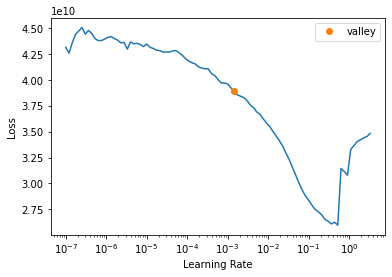

In [ ]:
learn.model

# select the appropriate learning rate
learn.lr_find()

# we typically find the point where the slope is steepest
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(50,lr_max=1e-3)

epoch,train_loss,valid_loss,_rmse,time
0,51018313728.000000,44869779456.000000,211824.906250,00:00
1,48207511552.000000,45938769920.000000,214333.312500,00:00
2,45495328768.000000,44688183296.000000,211395.796875,00:00
3,42797678592.000000,41695510528.000000,204194.781250,00:00
4,39609995264.000000,33442328576.000000,182872.437500,00:00
5,35860819968.000000,24790302720.000000,157449.375000,00:00
6,31787245568.000000,21019021312.000000,144979.375000,00:00
7,27886673920.000000,13783706624.000000,117404.031250,00:00
8,24435415040.000000,16939402240.000000,130151.468750,00:00
9,21531781120.000000,9177479168.000000,95799.164062,00:00


In [ ]:
learn.show_results()

,MSSubClass,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition,LotFrontage_na,MasVnrArea_na,GarageYrBlt_na,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,SalePrice_pred
0,6.0,4.0,2.0,4.0,4.0,1.0,5.0,1.0,16.0,3.0,3.0,1.0,6.0,4.0,2.0,14.0,8.0,2.0,3.0,5.0,3.0,3.0,4.0,2.0,3.0,6.0,2.0,1.0,2.0,5.0,3.0,7.0,5.0,2.0,2.0,5.0,5.0,3.0,9.0,5.0,1.0,1.0,1.0,1.220838,-0.005855,0.652660,-0.537187,0.720989,0.439900,3.012275,1.606118,-0.294596,-0.979492,0.603764,0.443103,1.677812,-0.128557,1.702809,1.133535,-0.238895,0.791670,1.194156,0.151647,-0.214271,1.518679,0.604063,0.524450,1.651604,2.384485,1.235624,1.670994,3.136686,-0.099000,-0.268170,-0.065199,-0.084339,0.645475,0.143126,341000.0,322598.406250
1,1.0,4.0,2.0,1.0,3.0,1.0,2.0,1.0,7.0,5.0,3.0,1.0,3.0,4.0,2.0,7.0,7.0,2.0,3.0,5.0,2.0,4.0,4.0,4.0,2.0,6.0,2.0,1.0,2.0,5.0,3.0,7.0,3.0,6.0,3.0,5.0,5.0,3.0,9.0,5.0,2.0,1.0,1.0,-0.364664,0.383794,-0.070591,1.305498,-0.563928,1.022828,-0.166816,0.636629,-0.294596,0.003401,0.569071,1.265916,-0.825136,-0.128557,0.223927,1.133535,-0.238895,-1.021409,-0.781445,0.151647,-0.214271,0.284290,0.604063,0.524450,0.306365,2.108238,0.111401,-0.703437,-0.367786,9.168747,-0.268170,-0.065199,-0.084339,1.768485,0.143126,224000.0,179822.015625
2,15.0,4.0,2.0,4.0,3.0,1.0,5.0,2.0,12.0,3.0,3.0,2.0,3.0,2.0,2.0,9.0,9.0,4.0,4.0,3.0,2.0,4.0,4.0,1.0,2.0,6.0,2.0,1.0,2.0,5.0,4.0,7.0,5.0,1.0,1.0,5.0,5.0,3.0,9.0,5.0,2.0,1.0,1.0,-0.364664,2.010550,-1.517094,-1.458529,-0.333302,-0.483070,0.255964,1.575617,-0.294596,-1.089210,0.460367,1.218899,-0.825136,-0.128557,0.189712,1.133535,-0.238895,-1.021409,-0.781445,0.151647,-0.214271,0.284290,0.604063,-0.197246,2.996844,4.130923,2.731948,-0.703437,-0.367786,-0.099000,-0.268170,-0.065199,-0.084339,-1.226210,-0.609897,168000.0,206759.000000
3,1.0,4.0,2.0,4.0,4.0,1.0,5.0,1.0,13.0,3.0,3.0,1.0,3.0,2.0,2.0,14.0,15.0,3.0,4.0,5.0,2.0,4.0,4.0,4.0,2.0,6.0,2.0,3.0,2.0,5.0,3.0,7.0,0.0,2.0,3.0,5.0,5.0,3.0,9.0,5.0,1.0,1.0,1.0,-0.100414,-0.154779,-0.793843,1.305498,-0.596875,1.022828,-0.562144,0.451446,-0.294596,-0.460616,-0.097029,-0.384934,-0.825136,-0.128557,-0.977426,1.133535,-0.238895,-1.021409,-0.781445,-1.053274,-0.214271,-0.332905,-0.946587,-1.079319,-1.038875,-1.094346,-0.743641,-0.425906,-0.367786,-0.099000,-0.268170,-0.065199,-0.084339,-0.477536,-0.609897,134500.0,155555.484375
4,1.0,4.0,2.0,1.0,4.0,1.0,5.0,1.0,13.0,3.0,3.0,1.0,3.0,2.0,2.0,10.0,11.0,2.0,4.0,5.0,2.0,3.0,4.0,4.0,2.0,6.0,2.0,3.0,2.0,5.0,4.0,7.0,3.0,2.0,2.0,5.0,5.0,3.0,9.0,5.0,2.0,1.0,1.0,-0.364664,-0.101703,-0.070591,-0.537187,-0.267409,-1.065999,0.794049,0.377373,-0.294596,0.499419,0.795730,0.623338,-0.825136,-0.128557,-0.243688,1.133535,-0.238895,-1.021409,1.194156,0.151647,-0.214271,-0.332905,2.154713,-0.678377,0.306365,0.188560,-0.743641,0.468360,-0.367786,-0.099000,3.112393,-0.065199,-0.084339,0.271138,0.896149,159000.0,169275.343750
5,6.0,4.0,2.0,1.0,4.0,1.0,1.0,1.0,15.0,5.0,3.0,1.0,6.0,2.0,2.0,7.0,7.0,2.0,4.0,3.0,2.0,3.0,2.0,4.0,1.0,6.0,2.0,5.0,2.0,5.0,4.0,7.0,5.0,2.0,1.0,5.0,5.0,3.0,9.0,5.0,2.0,1.0,1.0,-0.364664,0.149140,-0.070591,1.305498,0.193843,0.488477,1.765895,1.002638,-0.294596,-0.302896,0.647708,1.009930,2.220537,-0.128557,2.565807,1.133535,-0.238895,0.791670,1.194156,1.356568,-0.214271,2.753067,0.604063,-0.117057,0.306365,0.680185,3.610741,3.644547,-0.367786,-0.0

   MSZoning  Street  LotShape  LandContour  Utilities  LotConfig  LandSlope  \
0       4.0     2.0       4.0          4.0        1.0        5.0        1.0   

   Neighborhood  Condition1  Condition2  ...  OpenPorchSF  EnclosedPorch  \
0           6.0         3.0         3.0  ...     0.198851      -0.351432   

   3SsnPorch  ScreenPorch  PoolArea   MiscVal   MoSold    YrSold  SalePrice  \
0  -0.118479    -0.269866  -0.06476 -0.080333 -1.59475  0.143694   0.362298   

   SalePrice  
0   0.223319  

[1 rows x 80 columns]

Text(0.5, 0, 'Epoch')

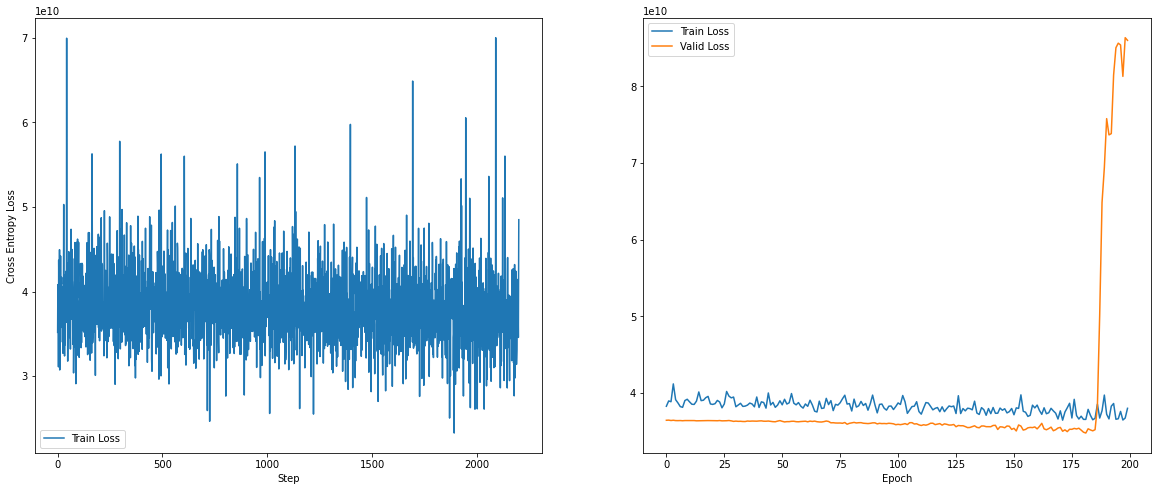

In [ ]:
final